<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Study-predictions" data-toc-modified-id="Study-predictions-1">Study predictions</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.3">Load data</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.4">Code</a></span></li><li><span><a href="#Compare-new-model-with-4-outputs-vs-old" data-toc-modified-id="Compare-new-model-with-4-outputs-vs-old-1.5">Compare new model with 4 outputs vs old</a></span><ul class="toc-item"><li><span><a href="#Load-models-and-make-predictions" data-toc-modified-id="Load-models-and-make-predictions-1.5.1">Load models and make predictions</a></span></li><li><span><a href="#Take-action-distribution" data-toc-modified-id="Take-action-distribution-1.5.2">Take action distribution</a></span></li><li><span><a href="#Goodness-of-policy" data-toc-modified-id="Goodness-of-policy-1.5.3">Goodness of policy</a></span></li><li><span><a href="#Correctness-of-predictions" data-toc-modified-id="Correctness-of-predictions-1.5.4">Correctness of predictions</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.6">Summary</a></span></li></ul></li></ul></div>

# Study predictions

## Goal

The goal of this notebook is to study predictions of a model on the validation set with the aim to improve metrics or losses.

## Imports

In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve

import luxai.cunet
from luxai.data import combine_data_for_training, load_match
from luxai.input_features import CHANNELS_MAP

In [26]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Load data

In [16]:
df = pd.read_csv('/mnt/hdd0/Kaggle/luxai/models/42_curriculum_learning_with_best_stages/seed0/stage4/val.csv')
df.head()

,Id,EpisodeId,Index,Reward,State,SubmissionId,InitialConfidence,InitialScore,UpdatedConfidence,UpdatedScore,FinalScore,Team
0,75076972,29991187,0,890041.0,2,23297953,35.00000,1957.279341,35.000000,1959.003122,2021.185199,Toad Brigade
1,75988959,30447180,1,1310051.0,2,23297953,35.00000,2011.593075,35.000000,2013.044434,2021.185199,Toad Brigade
2,72070727,28487063,1,230012.0,2,23297953,42.79739,1466.705040,42.321043,1472.138593,2021.185199,Toad Brigade
3,74444543,29674972,1,1030042.0,2,23297953,35.00000,1932.343041,35.000000,1933.920986,2021.185199,Toad Brigade
4,73255322,29079361,0,310016.0,2,23297953,35.00000,1819.460414,35.000000,1821.367935,2021.185199,Toad Brigade


In [17]:
def load_data(df):
    matches = []
    for episode_id, player in tqdm(zip(df.EpisodeId, df.Index), total=len(df), desc='Loading matches'):
        matches.append(load_match(episode_id, player, '', '/home/gbarbadillo/luxai_ssd/matches_npz_v2'))
    return combine_data_for_training(matches)

In [18]:
data = load_data(df.loc[:5])

Loading matches:   0%|          | 0/6 [00:00<?, ?it/s]

Inputs shapes [(2157, 32, 32, 28), (2157, 1, 12)]
Outputs shapes [(2157, 32, 32, 11), (2157, 32, 32, 4)]


## Code

In [19]:
def get_active_units_data(data, preds, name):
    idx = ['unit', 'city'].index(name)
    mask = data[1][idx][..., -1]
    y_true = data[1][idx][mask == 1][..., :-1]
    if len(preds) == 4:
        y_action = preds[2*idx][mask == 1]
        y_policy = preds[2*idx + 1][mask == 1]
    elif len(preds) == 2:
        y_policy = preds[idx][mask == 1]
        y_action = np.max(y_policy, axis=-1, keepdims=True)
    return dict(y_true=y_true, y_policy=y_policy, y_action=y_action, name=name)

In [33]:
def compute_eer(distances, labels):
    # Calculate evaluation metrics
    fprs, tprs, _ = roc_curve(labels, distances)
    eer = fprs[np.nanargmin(np.absolute((1 - tprs) - fprs))]
    return eer

def plot_take_action_distribution(y_true, y_action, name, **kwargs):
    bins = np.linspace(0, 1, 100)
    no_action = np.max(y_true, axis=-1) == 0
    plt.hist(y_action[no_action], bins=bins, density=True, cumulative=-1, label='no action');
    take_action = np.max(y_true, axis=-1) > 0
    plt.hist(y_action[take_action], bins=bins, density=True, cumulative=1, label='take action', alpha=0.5);
    plt.title('Take action distribution for %s. EER %.1f%%' % (name, compute_eer(y_action, np.max(y_true, axis=-1)>0)*100))
    plt.legend(loc=0)
    plt.xlabel('prediction value')
    plt.ylabel('cumulative distribution')

In [51]:
def plot_policy_goodness(y_true, y_policy, name, **kwargs):
    bins = np.linspace(0, 1, 100)
    take_action = np.max(y_true, axis=-1) > 0
    error = 1 - np.mean(np.argmax(y_true[take_action], axis=-1) == np.argmax(y_policy[take_action], axis=-1))
    values = np.max(y_policy[take_action], axis=-1)
    plt.hist(values, bins=bins, density=True, cumulative=1, label='take action');
    plt.title('Max prediction of policy for %s. Error %.1f%%' % (name, error*100)) 
    plt.xlabel('prediction value')
    plt.ylabel('cumulative distribution')

In [70]:
def print_policy_correctness(y_true, y_policy, y_action, name, threshold):
    """
    Combines the action and policy prediction to see how good the decisions are
    
    Frecuency of each one and accuracy
    """
    no_action = np.max(y_true, axis=-1) == 0
    print('No action frequency: %.1f%%\t error %.1f%%' % (np.mean(no_action)*100, 100*( 1 - np.mean(y_action[no_action] < threshold))))
    
    take_action = np.max(y_true, axis=-1) > 0
    accuracy = np.mean((y_action[take_action] > threshold)*(np.argmax(y_true[take_action], axis=-1) == np.argmax(y_policy[take_action], axis=-1)))
    print('Take action frequency: %.1f%%\t error %.1f%%' % (np.mean(take_action)*100, 100*( 1 - accuracy)))

## Compare new model with 4 outputs vs old

### Load models and make predictions

In [30]:
new_model = keras.models.load_model('/mnt/hdd0/Kaggle/luxai/models/45_new_model_output/01_baseline_all_loss_weights_to_1/best_val_loss_model.h5', compile=False)
new_preds = new_model.predict(data[0], batch_size=32)

In [22]:
old_model = keras.models.load_model('/mnt/hdd0/Kaggle/luxai/models/42_curriculum_learning_with_best_stages/seed0/stage4/best_val_loss_model.h5', compile=False)
old_preds = old_model.predict(data[0], batch_size=32)

### Take action distribution

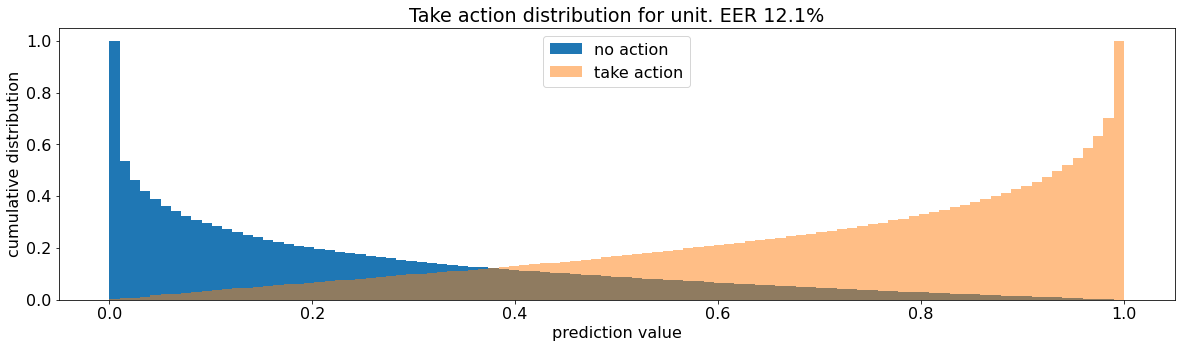

In [34]:
plot_take_action_distribution(**get_active_units_data(data, new_preds, name='unit'))

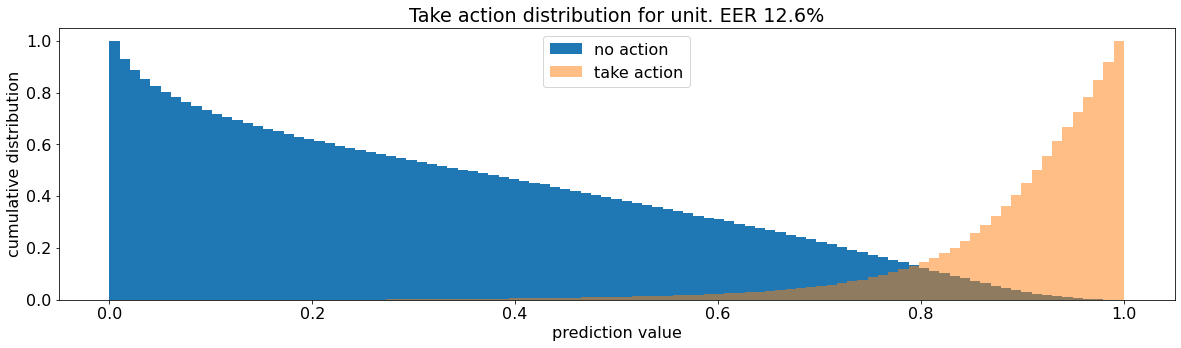

In [35]:
plot_take_action_distribution(**get_active_units_data(data, old_preds, name='unit'))

Althought the distributions are very different we can see that the EER is almost the same.

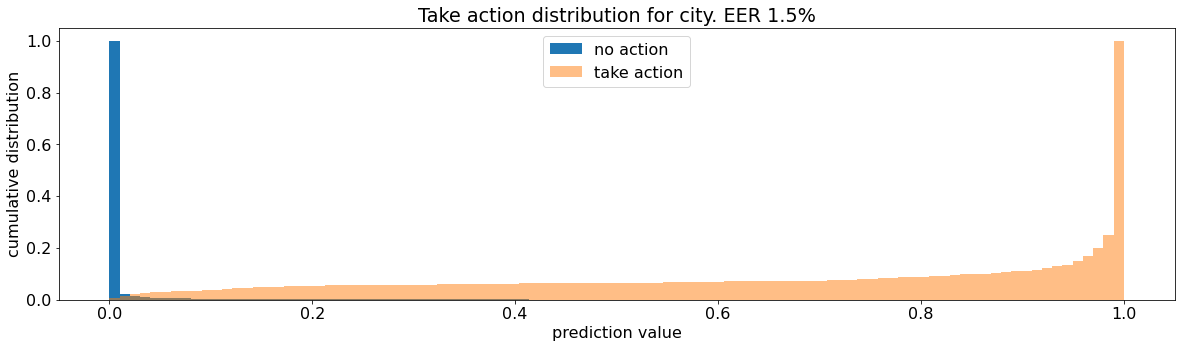

In [36]:
plot_take_action_distribution(**get_active_units_data(data, new_preds, name='city'))

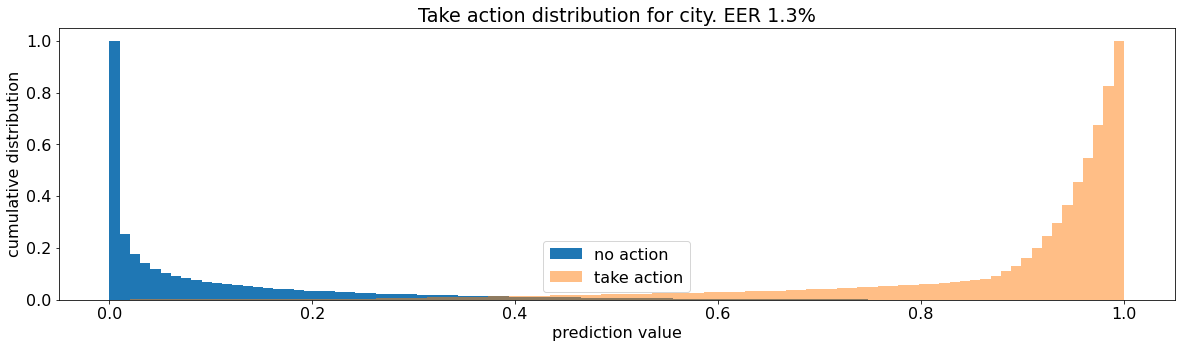

In [37]:
plot_take_action_distribution(**get_active_units_data(data, old_preds, name='city'))

In the case of city the old predictions are better.

### Goodness of policy

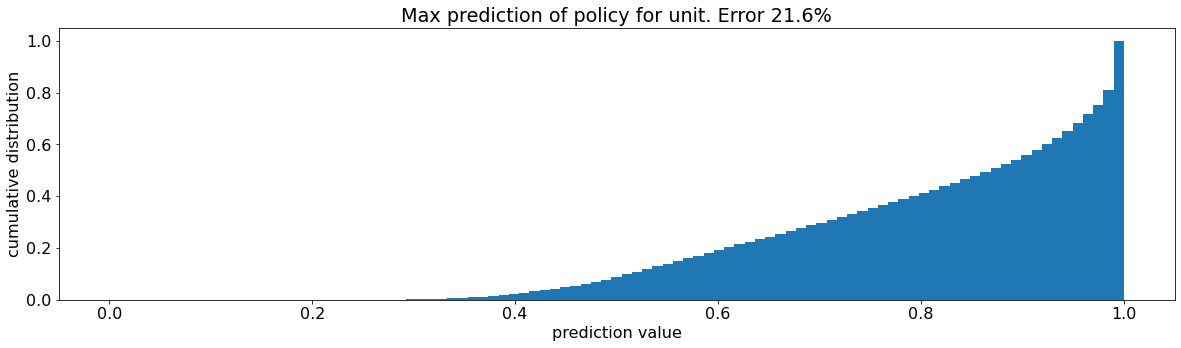

In [53]:
plot_policy_goodness(**get_active_units_data(data, new_preds, name='unit'))

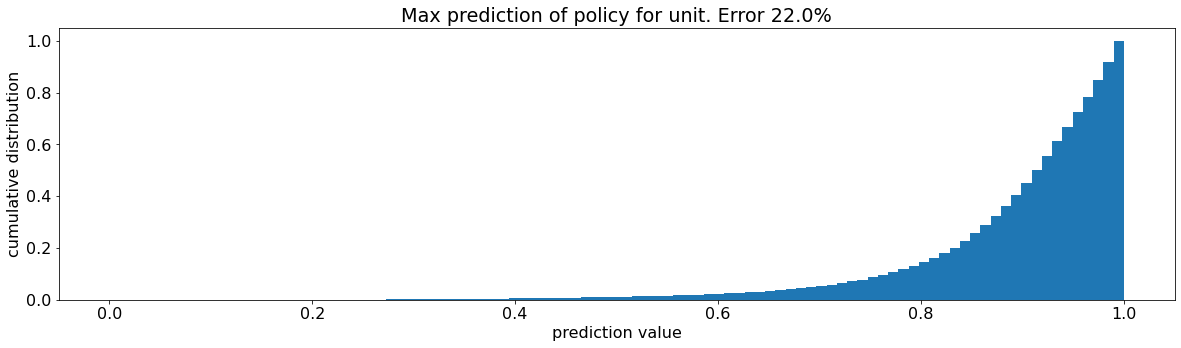

In [54]:
plot_policy_goodness(**get_active_units_data(data, old_preds, name='unit'))

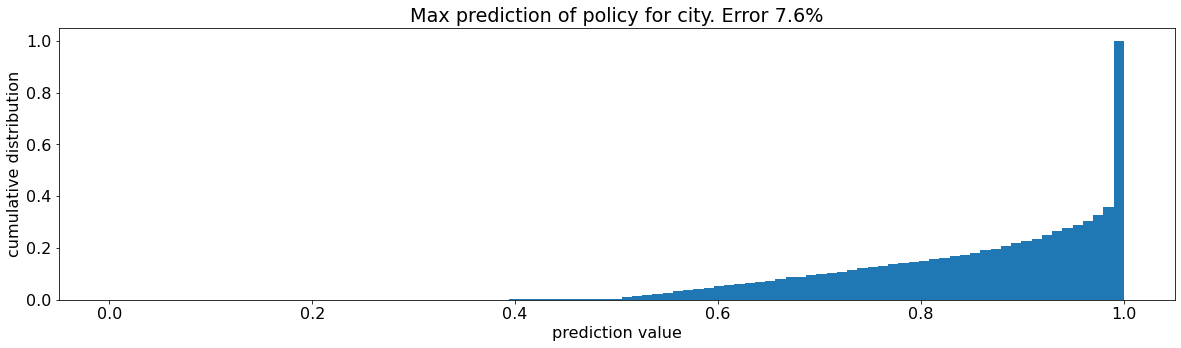

In [55]:
plot_policy_goodness(**get_active_units_data(data, new_preds, name='city'))

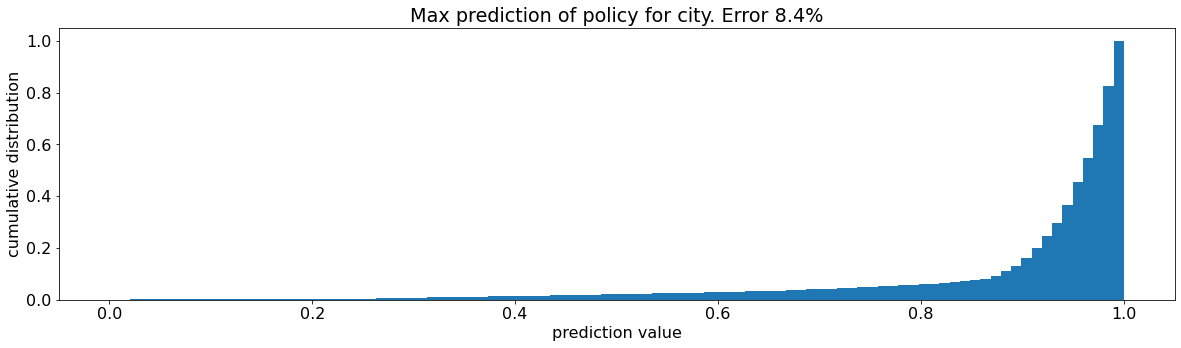

In [56]:
plot_policy_goodness(**get_active_units_data(data, old_preds, name='city'))

This shows that both for unit and cities the new policy is slightly better than the old one.

### Correctness of predictions

In [71]:
print_policy_correctness(**get_active_units_data(data, new_preds, name='unit'), threshold=0.5)

No action frequency: 63.3%	 error 8.8%
Take action frequency: 36.7%	 error 34.6%


In [74]:
print_policy_correctness(**get_active_units_data(data, new_preds, name='unit'), threshold=0.05)

No action frequency: 63.3%	 error 36.5%
Take action frequency: 36.7%	 error 22.9%


In [72]:
print_policy_correctness(**get_active_units_data(data, old_preds, name='unit'), threshold=0.5)

No action frequency: 63.3%	 error 38.5%
Take action frequency: 36.7%	 error 22.8%


Results seem to be very similar yet, I have launched a train from zero to see if that could be different. One good thing I'm seeing is that now training metrics are much better and show clear overfitting, so using more dropout could be beneficial.

In [75]:
print_policy_correctness(**get_active_units_data(data, new_preds, name='city'), threshold=0.5)

No action frequency: 97.7%	 error 0.1%
Take action frequency: 2.3%	 error 13.6%


In [78]:
print_policy_correctness(**get_active_units_data(data, new_preds, name='city'), threshold=0.05)

No action frequency: 97.7%	 error 0.7%
Take action frequency: 2.3%	 error 10.2%


In [76]:
print_policy_correctness(**get_active_units_data(data, old_preds, name='city'), threshold=0.5)

No action frequency: 97.7%	 error 0.7%
Take action frequency: 2.3%	 error 10.3%


## Summary

I have created a notebook that allows to directly compare old vs new models. 

On the first comparison we have seen that althougth action prediction has a different working point the results are almost the same as the old model.
A training from zero has been launched to see if there is any difference.

It seems that training metrics are better now and could be giving more information to guide architecture or hyperparameter tuning.